In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [42]:
df = pd.read_csv('./output/data/merged_df.csv')

In [43]:
df.columns

Index(['file_path', 'sampling_rate', 'rms', 'dbfs', 'label', 'duration',
       'mfcc_1_mean', 'mfcc_2_mean', 'mfcc_3_mean', 'mfcc_4_mean',
       'mfcc_5_mean', 'mfcc_6_mean', 'mfcc_7_mean', 'mfcc_8_mean',
       'mfcc_9_mean', 'mfcc_10_mean', 'mfcc_11_mean', 'mfcc_12_mean',
       'mfcc_13_mean', 'mfcc_14_mean', 'mfcc_15_mean', 'mfcc_16_mean',
       'mfcc_17_mean', 'mfcc_18_mean', 'mfcc_19_mean', 'mfcc_20_mean',
       'mfcc_21_mean', 'mfcc_22_mean', 'mfcc_23_mean', 'mfcc_24_mean',
       'mfcc_25_mean', 'mfcc_26_mean', 'mfcc_27_mean', 'mfcc_28_mean',
       'mfcc_29_mean', 'mfcc_30_mean'],
      dtype='object')

In [44]:
# Drop the 'file_path' column
data = df.drop(columns=['file_path', 'sampling_rate'])

# Convert 'label' column values from 'fake' and 'real' to 0 and 1
data['label'] = data['label'].apply(lambda x: 0 if x == 'fake' else 1)

# Display the updated dataframe
data.head()

,rms,dbfs,label,duration,mfcc_1_mean,mfcc_2_mean,mfcc_3_mean,mfcc_4_mean,mfcc_5_mean,mfcc_6_mean,...,mfcc_21_mean,mfcc_22_mean,mfcc_23_mean,mfcc_24_mean,mfcc_25_mean,mfcc_26_mean,mfcc_27_mean,mfcc_28_mean,mfcc_29_mean,mfcc_30_mean
0,0.061510,-24.220951,1,6.840000,-304.341270,113.709097,-44.021291,28.256102,13.641230,-13.230529,...,-7.879508,-11.564848,-7.241586,-3.500644,-8.572959,-7.769196,-6.200805,-9.601032,-1.045484,1.696635
1,0.034738,-29.183570,1,5.920000,-313.729559,133.650065,-45.776206,-0.649869,-4.962584,-27.823752,...,-7.809381,-3.840896,-4.639575,-5.083332,-2.645830,-3.523515,-4.064678,-1.823462,-1.784046,-3.711713
2,0.101507,-19.870003,1,9.849958,-338.528304,110.269715,-26.445261,7.784086,12.008307,-15.176674,...,-6.991639,-4.952648,-4.918112,-5.376414,-5.329774,-4.305240,-3.679742,-3.917728,-2.481780,-1.619357
3,0.027996,-31.057756,1,5.529958,-288.435487,117.139206,-53.460400,14.722782,-4.214957,-40.313201,...,-8.898185,-8.144262,-5.093298,0.412901,0.513141,1.108503,1.737505,-0.865436,0.617007,0.743553
4,0.063247,-23.979015,1,5.470000,-322.176792,141.187411,-44.837019,16.826968,1.227255,-33.146475,...,-5.316242,-8.805407,-7.705508,-6.848758,-7.903668,-7.104397,-7.859149,-6.783533,-4.680488,-3.103890


In [45]:
data.shape

(11160, 34)

In [46]:
# 1. Load and preprocess data
# features = data.drop(columns=['label', 'lpc_1_mean', 'lpc_10_mean', 'lpc_11_mean', 'lpc_12_mean', 'mfcc_3_mean', 'mfcc_2_mean',
#                               'spectral_centroid_mean', 'spectral_bandwidth_mean', 'spectral_rolloff_mean',
#                               'spectral_contrast_1_mean', 'spectral_contrast_2_mean', 'spectral_contrast_3_mean',
#                               'spectral_contrast_4_mean', 'spectral_contrast_5_mean', 'spectral_contrast_6_mean', 'chroma_1_mean',
#                               'chroma_2_mean', 'chroma_3_mean', 'zcr_mean'], axis=1).copy()
features = data.drop(columns=['label', 'rms', 'dbfs', 'duration'], axis=1).copy()
labels = data['label']

In [47]:
features.columns

Index(['mfcc_1_mean', 'mfcc_2_mean', 'mfcc_3_mean', 'mfcc_4_mean',
       'mfcc_5_mean', 'mfcc_6_mean', 'mfcc_7_mean', 'mfcc_8_mean',
       'mfcc_9_mean', 'mfcc_10_mean', 'mfcc_11_mean', 'mfcc_12_mean',
       'mfcc_13_mean', 'mfcc_14_mean', 'mfcc_15_mean', 'mfcc_16_mean',
       'mfcc_17_mean', 'mfcc_18_mean', 'mfcc_19_mean', 'mfcc_20_mean',
       'mfcc_21_mean', 'mfcc_22_mean', 'mfcc_23_mean', 'mfcc_24_mean',
       'mfcc_25_mean', 'mfcc_26_mean', 'mfcc_27_mean', 'mfcc_28_mean',
       'mfcc_29_mean', 'mfcc_30_mean'],
      dtype='object')

In [48]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Input, LSTM, Bidirectional, Dropout, Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
from utils import create_sequences
import pickle

In [50]:
# 1. Create sequences
sequence_length = 10  # Example value, adjust as needed
overlap = 5  # Example value, adjust as needed
print(features.shape)
sequences, indices = create_sequences(features, sequence_length, overlap)
labels = labels[indices]

# 2. Pad sequences
padded_sequences = pad_sequences(
    sequences, maxlen=sequence_length, padding="pre", truncating="post"
)

# Scale features
scaler = StandardScaler()
with open('./output/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Reshape padded_sequences for scaling
num_samples, seq_len, num_features = padded_sequences.shape
padded_sequences_reshaped = padded_sequences.reshape(
    num_samples, seq_len * num_features
)

# Fit and transform the scaler on the reshaped data
padded_sequences_scaled = scaler.fit_transform(padded_sequences_reshaped)

# Reshape the scaled data back to the original shape
padded_sequences = padded_sequences_scaled.reshape(
    num_samples, seq_len, num_features
)
print(padded_sequences.shape)
print(labels.shape)
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    padded_sequences, labels, test_size=0.2, random_state=42
)

(11160, 30)
(2231, 10, 30)
(2231,)


In [40]:
X_test, y_test

(array([[[-0.63409461,  1.10639166,  1.62533583, ..., -1.38895851,
           0.08938742, -0.06027739],
         [-2.1874602 , -1.51510318,  1.22287532, ...,  0.17460816,
           0.53571976,  0.73977596],
         [-0.349188  , -0.32221127,  0.54373326, ..., -0.22357587,
          -0.72768693, -0.42220122],
         ...,
         [-1.34516281, -1.19747906,  1.12030975, ..., -0.22377381,
          -0.29944384,  0.33253956],
         [ 1.02709948, -1.48563099, -1.81140207, ...,  0.99469622,
           0.95408505,  1.83538729],
         [-0.41243423, -0.06178202,  0.36039019, ...,  0.59600237,
          -0.6945707 ,  0.34627069]],
 
        [[ 1.12692849,  0.13831252, -1.6197998 , ...,  0.1475564 ,
           0.08938742, -0.06027739],
         [ 1.59627224, -2.3868417 , -1.53986959, ...,  0.57496869,
           0.53571976,  0.36459065],
         [-0.38351898, -1.66281186, -0.03284324, ..., -0.22357587,
          -0.29944384, -0.79942625],
         ...,
         [-1.07048526,  0.6097668

In [ ]:
# 2. Create LSTM model
model = Sequential()
input_shape = (X_train.shape[1], X_train.shape[2])
model.add(Input(shape=input_shape))
model.add((LSTM(64, return_sequences=True)))
model.add(Dropout(0.2))
model.add((LSTM(64, return_sequences=True)))
model.add(Dropout(0.2))
model.add((LSTM(64, return_sequences=False)))
model.add(Dense(32, activation='relu', kernel_regularizer='l2'))
model.add(Dense(1, activation='sigmoid'))

# 3. Compile model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001, clipvalue=1.0), loss="binary_crossentropy", metrics=["accuracy"])

In [103]:
# Callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint("best_model.keras", save_best_only=True, monitor="val_loss")
def scheduler(epoch, lr):
    if epoch > 0 and epoch % 3 == 0:
        return lr * 0.2
    return lr

reduce_lr = LearningRateScheduler(scheduler)

history = model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, model_checkpoint, reduce_lr],
)

Epoch 1/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.8142 - loss: 0.9032 - val_accuracy: 0.9356 - val_loss: 0.4066 - learning_rate: 0.0010
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.9695 - loss: 0.3300 - val_accuracy: 0.9944 - val_loss: 0.1886 - learning_rate: 0.0010
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.9869 - loss: 0.1847 - val_accuracy: 0.9916 - val_loss: 0.1324 - learning_rate: 0.0010
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9943 - loss: 0.1235 - val_accuracy: 0.9888 - val_loss: 0.1126 - learning_rate: 2.0000e-04
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9984 - loss: 0.1021 - val_accuracy: 0.9916 - val_loss: 0.1013 - learning_rate: 2.0000e-04
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9992 - loss: 0.0927 - val_accuracy: 0.9972 - val_loss: 0.0896 - learning_rate: 2.0000e-04
Epoch 7/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9998 - los

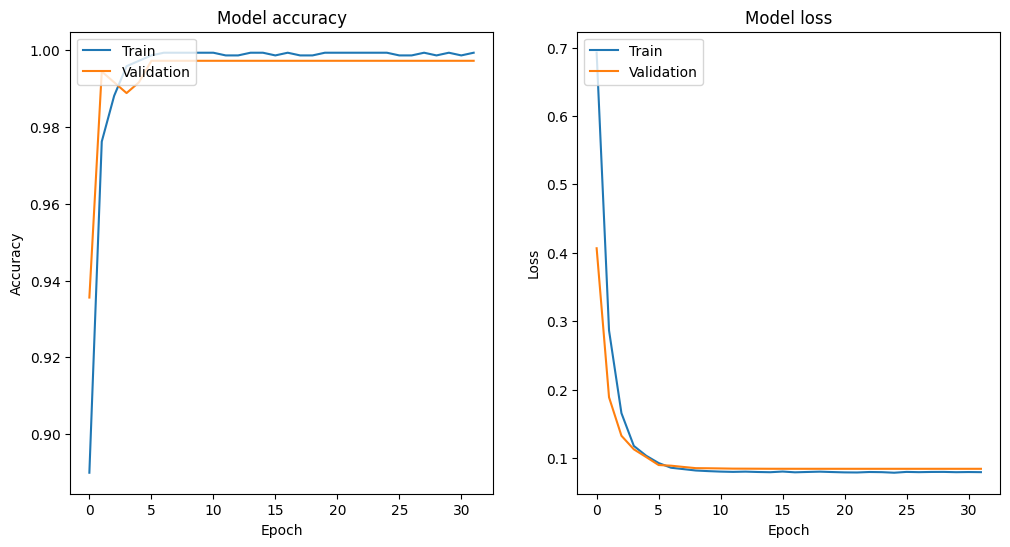

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9871 - loss: 0.1113
Test Loss: 0.1141124814748764
Test Accuracy: 0.9865771532058716


In [104]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# Evaluate
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")